<a href="https://colab.research.google.com/github/DRA-chaos/Quantum-Convolutional-Neural-Network/blob/main/CIFAR_Hybrid_QNN_3_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

     |████████████████████████████████| 6.0MB 7.0MB/s 
     |████████████████████████████████| 18.0MB 174kB/s 
     |████████████████████████████████| 235kB 54.9MB/s 
     |████████████████████████████████| 215kB 57.0MB/s 
     |████████████████████████████████| 2.1MB 42.1MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 1.5MB 33.8MB/s 
     |████████████████████████████████| 194kB 48.2MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
     |████████████████████████████████| 614kB 32.2MB/s 
     |████████████████████████████████| 3.2MB 30.3MB/s 
     |████████████████████████████████| 6.3MB 31.2MB/s 
  Created wheel for qiskit: filename=qiskit-0.27.0-cp37-none-any.whl size=10505 sha256=813a8dfe7096af5097fe901c2dfb38969ddd5e5f3e9c891140d4260bd5bd01e2
  Stored in directory: /root/.cache/pip/wheels/c6/54/d9/f0f711dc20aff31947456951374132d0e23ec527da8c15295d
  Created wheel for python-constraint: filename=python_constraint-1.4.0-p

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

To connect PyTorch to Qiskit, we need to define a function that converts tensors so obtained from PyTorch to a list so that the list could be fed into the Quantum Circuit in Qiskit.

In [6]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [8]:

import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

We use a 1 qubit circuit with 1 trainable parameter to create a 'Quantum Class'

In [9]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

To measure the output (in the z basis), the expectation must be calculated, so let's test the implementation below

In [10]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.43


┌───┐ ░ ┌───────────┐ ░ ┌─┐
   q_0: ┤ H ├─░─┤ RY(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

**Creating the quantum classical hybrid class using Pytorch**

The functions needed for backpropagation can be created by PyTorch (using the parameter shift rule). The forward and backward passes contain elements from the Qiskit class

In [11]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

## **Data loading and pre-processing**

Here , we create a simple hybrid neural network to classify images of two types ; Aeroplanes and Automobiles (labelled 0 and 1) from the CIFAR-10 dataset.

Let's first load the training data

In [12]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)

labels = cifar_trainset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx] 
cifar_trainset.data = cifar_trainset.data[idx]

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)


Extracting ./data1/cifar-10-python.tar.gz to ./data1


We now filter for pictures containing Aeroplanes and Automobiles (labelled 0 and 1 respectively)

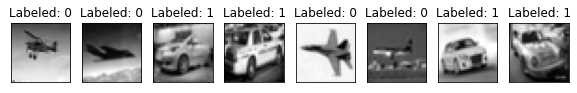

In [13]:
import numpy as np  
import matplotlib.pyplot as plt

n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))
      
    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

Now let's look at the testing data

In [14]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels = cifar_testset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_testset.targets = labels[idx] 
cifar_testset.data = cifar_testset.data[idx]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=True)

Files already downloaded and verified


**Creating the hybrid Neural Network**

We create a typical Convolutional Neural Network with two fully-connected layers at the end. The value of the last neuron of the fully-connected layer is fed as the parameter  
θ
  into our quantum circuit.

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

**Now let's train the network**

We can specify any PyTorch optimiser (here we use the Adam optimiser), learning rate and cost/loss function in order to train over multiple epochs. In this instance, we use  a learning rate of 0.001 and the negative log-likelihood loss function.
We then plot the training graph. We do this for 5, 10, 20, 30 epochs

EPOCHS=5, LEARNING RATE=0.001, OPTIMIZER = ADAM

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training [20%]	Loss: -0.5052
Training [40%]	Loss: -0.5321
Training [60%]	Loss: -0.5001
Training [80%]	Loss: -0.5297
Training [100%]	Loss: -0.4924


Text(0, 0.5, 'Neg Log Likelihood Loss')

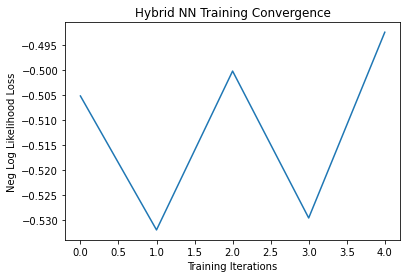

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

#Now plotting the training graph
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')


In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.4970
	Accuracy: 54.0%


EPOCHS=10, LEARNING RATE=0.001, OPTIMIZER = ADAM

Training [10%]	Loss: -0.5280
Training [20%]	Loss: -0.5042
Training [30%]	Loss: -0.5938
Training [40%]	Loss: -0.5990
Training [50%]	Loss: -0.5032
Training [60%]	Loss: -0.4837
Training [70%]	Loss: -0.4887
Training [80%]	Loss: -0.4844
Training [90%]	Loss: -0.5357
Training [100%]	Loss: -0.5017


Text(0, 0.5, 'Neg Log Likelihood Loss')

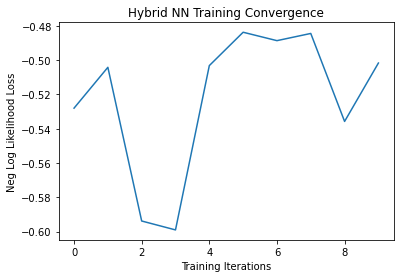

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_listA = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listA.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listA[-1]))

#Now plotting the training graph
plt.plot(loss_listA)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.4930
	Accuracy: 48.0%


## EPOCHS=15, LEARNING RATE=0.001, OPTIMIZER = ADAM



Training [7%]	Loss: -0.4895
Training [13%]	Loss: -0.5085
Training [20%]	Loss: -0.5188
Training [27%]	Loss: -0.5537
Training [33%]	Loss: -0.6589
Training [40%]	Loss: -0.7065
Training [47%]	Loss: -0.7236
Training [53%]	Loss: -0.7027
Training [60%]	Loss: -0.7484
Training [67%]	Loss: -0.7182
Training [73%]	Loss: -0.7767
Training [80%]	Loss: -0.7643
Training [87%]	Loss: -0.7959
Training [93%]	Loss: -0.7816
Training [100%]	Loss: -0.8006


Text(0, 0.5, 'Neg Log Likelihood Loss')

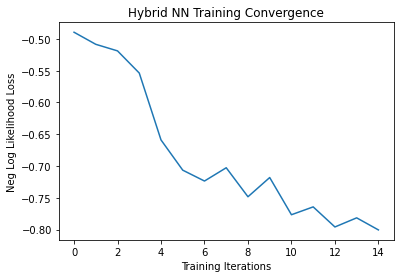

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 15
loss_listb = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listb.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listb[-1]))

#Now plotting the training graph
plt.plot(loss_listb)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7771
	Accuracy: 79.5%


CHANGING THE LEARNING RATES OF MODELS

EPOCHS=5 . lr=0.01 , OPTIMIZER=ADAM

Training [20%]	Loss: -0.4772
Training [40%]	Loss: -0.4975
Training [60%]	Loss: -0.4935
Training [80%]	Loss: -0.4934
Training [100%]	Loss: -0.4931


Text(0, 0.5, 'Neg Log Likelihood Loss')

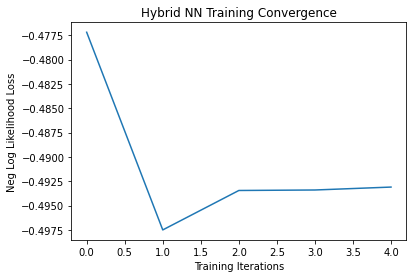

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

#Now plotting the training graph
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')


In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.4975
	Accuracy: 52.0%


EPOCHS=10 . lr=0.01 , OPTIMIZER=ADAM

Training [10%]	Loss: -0.5422
Training [20%]	Loss: -0.5037
Training [30%]	Loss: -0.5362
Training [40%]	Loss: -0.5038
Training [50%]	Loss: -0.5291
Training [60%]	Loss: -0.5588
Training [70%]	Loss: -0.4808
Training [80%]	Loss: -0.4940
Training [90%]	Loss: -0.5221
Training [100%]	Loss: -0.5003


Text(0, 0.5, 'Neg Log Likelihood Loss')

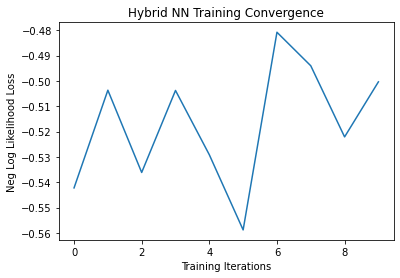

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.NLLLoss()

epochs = 10
loss_listc = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listc.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listc[-1]))

#Now plotting the training graph
plt.plot(loss_listc)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.4933
	Accuracy: 49.5%


EPOCHS=15 . lr=0.01 , OPTIMIZER=ADAM

Training [7%]	Loss: -0.4744
Training [13%]	Loss: -0.4899
Training [20%]	Loss: -0.4962
Training [27%]	Loss: -0.4908
Training [33%]	Loss: -0.4942
Training [40%]	Loss: -0.4918
Training [47%]	Loss: -0.4947
Training [53%]	Loss: -0.4948
Training [60%]	Loss: -0.4965
Training [67%]	Loss: -0.4943
Training [73%]	Loss: -0.4906
Training [80%]	Loss: -0.4974
Training [87%]	Loss: -0.4987
Training [93%]	Loss: -0.5004
Training [100%]	Loss: -0.4986


Text(0, 0.5, 'Neg Log Likelihood Loss')

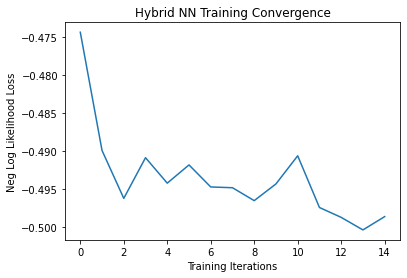

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.NLLLoss()

epochs = 15
loss_listd = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listd.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listd[-1]))

#Now plotting the training graph
plt.plot(loss_listd)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.5000
	Accuracy: 50.5%


# CHANGING THE LEARNING RATE TO 0.0001

Training [20%]	Loss: -0.4954
Training [40%]	Loss: -0.5352
Training [60%]	Loss: -0.6233
Training [80%]	Loss: -0.6638
Training [100%]	Loss: -0.7224


Text(0, 0.5, 'Neg Log Likelihood Loss')

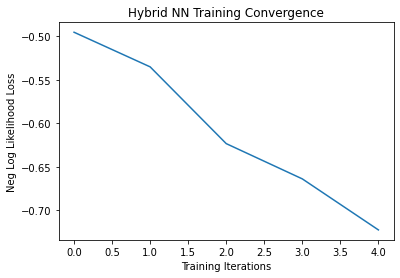

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

#Now plotting the training graph
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7205
	Accuracy: 77.0%


CHANGING THE OPTIMIZER TO SGD WITH EPOCHS=5

Training [20%]	Loss: -0.4989
Training [40%]	Loss: -0.5041
Training [60%]	Loss: -0.5019
Training [80%]	Loss: -0.5023
Training [100%]	Loss: -0.5011


Text(0, 0.5, 'Neg Log Likelihood Loss')

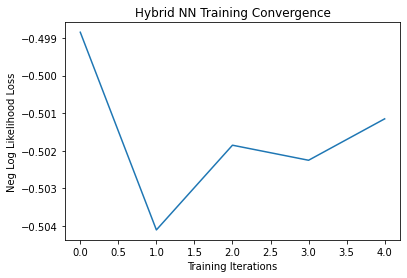

In [ ]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 5
loss_listF = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listF.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listF[-1]))

#Now plotting the training graph
plt.plot(loss_listF)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.5016
	Accuracy: 53.5%


Training [7%]	Loss: -0.4981
Training [13%]	Loss: -0.4989
Training [20%]	Loss: -0.5023
Training [27%]	Loss: -0.5069
Training [33%]	Loss: -0.5019
Training [40%]	Loss: -0.5023
Training [47%]	Loss: -0.4977
Training [53%]	Loss: -0.4933
Training [60%]	Loss: -0.4971
Training [67%]	Loss: -0.5066
Training [73%]	Loss: -0.5037
Training [80%]	Loss: -0.5057
Training [87%]	Loss: -0.4992
Training [93%]	Loss: -0.4983
Training [100%]	Loss: -0.4969


Text(0, 0.5, 'Neg Log Likelihood Loss')

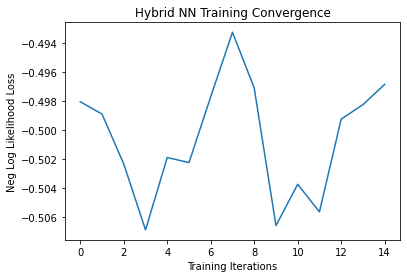

In [ ]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 15
loss_listF = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listF.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listF[-1]))

#Now plotting the training graph
plt.plot(loss_listF)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.4977
	Accuracy: 52.5%


Training [10%]	Loss: -0.5046
Training [20%]	Loss: -0.5092
Training [30%]	Loss: -0.5089
Training [40%]	Loss: -0.5046
Training [50%]	Loss: -0.5044
Training [60%]	Loss: -0.4957
Training [70%]	Loss: -0.5028
Training [80%]	Loss: -0.5029
Training [90%]	Loss: -0.5054
Training [100%]	Loss: -0.5056


Text(0, 0.5, 'Neg Log Likelihood Loss')

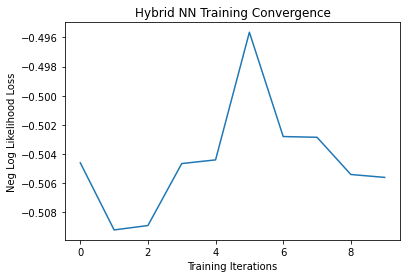

In [ ]:
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 10
loss_listF = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listF.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listF[-1]))

#Now plotting the training graph
plt.plot(loss_listF)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.5010
	Accuracy: 44.5%


Training [7%]	Loss: -0.4957
Training [13%]	Loss: -0.4907
Training [20%]	Loss: -0.5038
Training [27%]	Loss: -0.4972
Training [33%]	Loss: -0.4998
Training [40%]	Loss: -0.5032
Training [47%]	Loss: -0.4990
Training [53%]	Loss: -0.4989
Training [60%]	Loss: -0.4918
Training [67%]	Loss: -0.4946
Training [73%]	Loss: -0.4967
Training [80%]	Loss: -0.5035
Training [87%]	Loss: -0.5019
Training [93%]	Loss: -0.4957
Training [100%]	Loss: -0.4941


Text(0, 0.5, 'Neg Log Likelihood Loss')

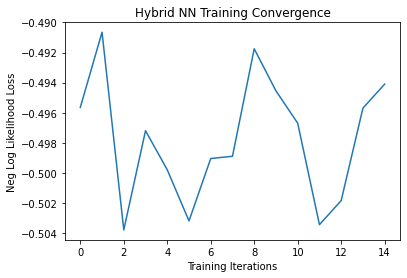

In [ ]:
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 15
loss_listF = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listF.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listF[-1]))

#Now plotting the training graph
plt.plot(loss_listF)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.4944
	Accuracy: 46.5%


Training [20%]	Loss: -0.5002
Training [40%]	Loss: -0.5042
Training [60%]	Loss: -0.4969
Training [80%]	Loss: -0.5091
Training [100%]	Loss: -0.5080


Text(0, 0.5, 'Neg Log Likelihood Loss')

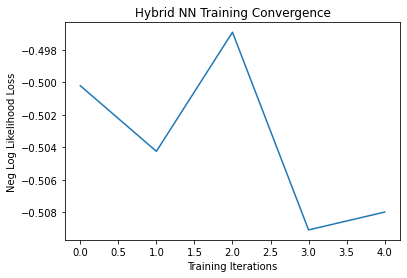

In [ ]:
##Adagrad

model = Net()
optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 5
loss_listG = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listG.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listG[-1]))

#Now plotting the training graph
plt.plot(loss_listG)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')





In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100))

Performance on test data:
	Loss: -0.5056
	Accuracy: 53.5%


Training [20%]	Loss: -0.5117
Training [40%]	Loss: -0.5431
Training [60%]	Loss: -0.6388
Training [80%]	Loss: -0.6352
Training [100%]	Loss: -0.6972


Text(0, 0.5, 'Neg Log Likelihood Loss')

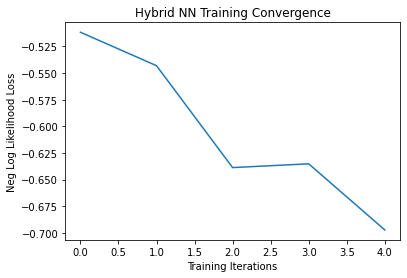

In [ ]:
#RMSprop

model = Net()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 5
loss_listG = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listG.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listG[-1]))

#Now plotting the training graph
plt.plot(loss_listG)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')




Training [10%]	Loss: -0.5151
Training [20%]	Loss: -0.6044
Training [30%]	Loss: -0.6655
Training [40%]	Loss: -0.7120
Training [50%]	Loss: -0.7180
Training [60%]	Loss: -0.7297
Training [70%]	Loss: -0.7405
Training [80%]	Loss: -0.7621
Training [90%]	Loss: -0.7607
Training [100%]	Loss: -0.7593


Text(0, 0.5, 'Neg Log Likelihood Loss')

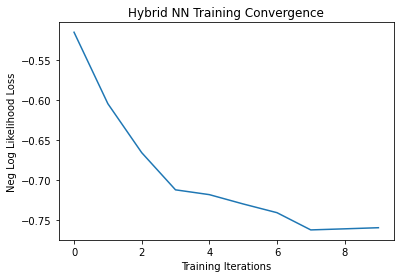

In [ ]:
model = Net()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 10
loss_listH = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listH.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listH[-1]))

#Now plotting the training graph
plt.plot(loss_listH)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100))

Performance on test data:
	Loss: -0.7584
	Accuracy: 82.0%


Training [7%]	Loss: -0.5003
Training [13%]	Loss: -0.5490
Training [20%]	Loss: -0.6000
Training [27%]	Loss: -0.6487
Training [33%]	Loss: -0.6569
Training [40%]	Loss: -0.7135
Training [47%]	Loss: -0.7159
Training [53%]	Loss: -0.7285
Training [60%]	Loss: -0.7237
Training [67%]	Loss: -0.7213
Training [73%]	Loss: -0.7359
Training [80%]	Loss: -0.7329
Training [87%]	Loss: -0.7362
Training [93%]	Loss: -0.7660
Training [100%]	Loss: -0.7558


Text(0, 0.5, 'Neg Log Likelihood Loss')

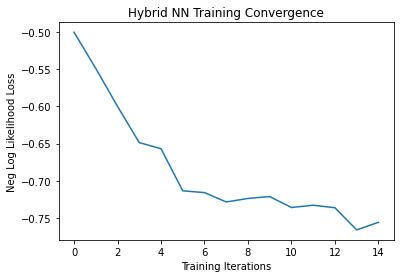

In [ ]:
model = Net()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 15
loss_listH = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listH.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listH[-1]))

#Now plotting the training graph
plt.plot(loss_listH)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100))

Performance on test data:
	Loss: -0.7502
	Accuracy: 82.0%


Training [5%]	Loss: -0.5114
Training [10%]	Loss: -0.5633
Training [15%]	Loss: -0.6175
Training [20%]	Loss: -0.6747
Training [25%]	Loss: -0.7106
Training [30%]	Loss: -0.7027
Training [35%]	Loss: -0.7247
Training [40%]	Loss: -0.7454
Training [45%]	Loss: -0.7532
Training [50%]	Loss: -0.7416
Training [55%]	Loss: -0.7440
Training [60%]	Loss: -0.7518
Training [65%]	Loss: -0.7597
Training [70%]	Loss: -0.7618
Training [75%]	Loss: -0.7655
Training [80%]	Loss: -0.7860
Training [85%]	Loss: -0.7676
Training [90%]	Loss: -0.7769
Training [95%]	Loss: -0.7898
Training [100%]	Loss: -0.7735


Text(0, 0.5, 'Neg Log Likelihood Loss')

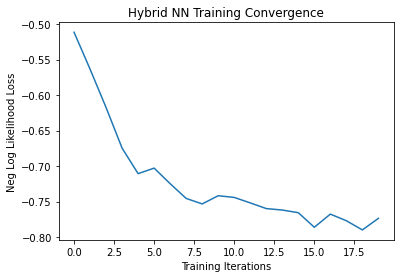

In [ ]:
model = Net()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 20
loss_listH = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listH.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listH[-1]))

#Now plotting the training graph
plt.plot(loss_listH)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100))

Performance on test data:
	Loss: -0.7632
	Accuracy: 84.0%


In [ ]:
#ADAM 20 epochs

Training [5%]	Loss: -0.4992
Training [10%]	Loss: -0.5337
Training [15%]	Loss: -0.5579
Training [20%]	Loss: -0.6158
Training [25%]	Loss: -0.6695
Training [30%]	Loss: -0.6953
Training [35%]	Loss: -0.7144
Training [40%]	Loss: -0.7258
Training [45%]	Loss: -0.7376
Training [50%]	Loss: -0.7276
Training [55%]	Loss: -0.7417
Training [60%]	Loss: -0.7588
Training [65%]	Loss: -0.7602
Training [70%]	Loss: -0.7756
Training [75%]	Loss: -0.7593
Training [80%]	Loss: -0.7566
Training [85%]	Loss: -0.7980
Training [90%]	Loss: -0.7818
Training [95%]	Loss: -0.8008
Training [100%]	Loss: -0.7947


Text(0, 0.5, 'Neg Log Likelihood Loss')

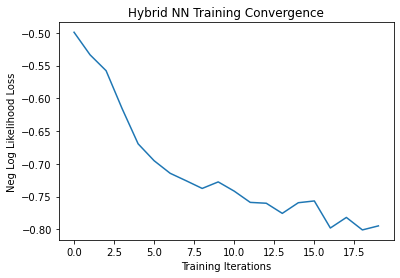

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 20
loss_listH = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listH.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listH[-1]))

#Now plotting the training graph
plt.plot(loss_listH)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100))

Performance on test data:
	Loss: -0.7592
	Accuracy: 80.5%


In [ ]:
loss.item()

-1.0

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100))

Performance on test data:
	Loss: -0.7574
	Accuracy: 82.0%


In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100))

Performance on test data:
	Loss: -0.7014
	Accuracy: 78.0%


In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7037
	Accuracy: 75.0%


Training [10%]	Loss: -0.5053
Training [20%]	Loss: -0.5300
Training [30%]	Loss: -0.5585
Training [40%]	Loss: -0.5793
Training [50%]	Loss: -0.6350
Training [60%]	Loss: -0.6670
Training [70%]	Loss: -0.6656
Training [80%]	Loss: -0.6722
Training [90%]	Loss: -0.6971
Training [100%]	Loss: -0.6982


Text(0, 0.5, 'Neg Log Likelihood Loss')

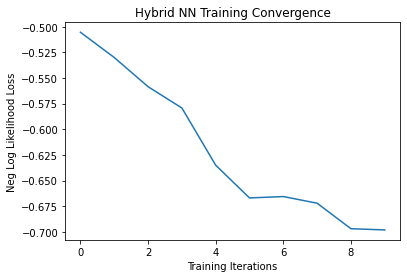

In [ ]:
model = Net()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 10
loss_listD = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listD.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listD[-1]))

#Now plotting the training graph
plt.plot(loss_listD)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.5023
	Accuracy: 51.5%


EPOCHS=10, OPTIMIZER=ADAM , LR=0.0001

Training [10%]	Loss: -0.5023
Training [20%]	Loss: -0.5102
Training [30%]	Loss: -0.6053
Training [40%]	Loss: -0.7084
Training [50%]	Loss: -0.7026
Training [60%]	Loss: -0.6976
Training [70%]	Loss: -0.7280
Training [80%]	Loss: -0.7256
Training [90%]	Loss: -0.7286
Training [100%]	Loss: -0.7354


Text(0, 0.5, 'Neg Log Likelihood Loss')

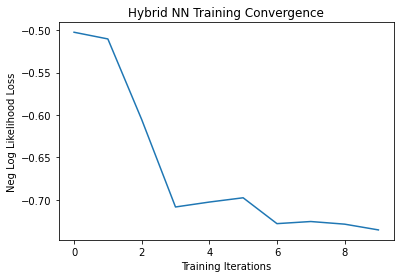

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 10
loss_listD = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listD.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listD[-1]))

#Now plotting the training graph
plt.plot(loss_listD)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7268
	Accuracy: 78.0%


EPOCHS=15, OPTIMIZER=ADAM , LR=0.0001

Training [7%]	Loss: -0.5130
Training [13%]	Loss: -0.5151
Training [20%]	Loss: -0.5861
Training [27%]	Loss: -0.6364
Training [33%]	Loss: -0.6840
Training [40%]	Loss: -0.6934
Training [47%]	Loss: -0.6964
Training [53%]	Loss: -0.7309
Training [60%]	Loss: -0.7272
Training [67%]	Loss: -0.7234
Training [73%]	Loss: -0.7522
Training [80%]	Loss: -0.7422
Training [87%]	Loss: -0.7594
Training [93%]	Loss: -0.7439
Training [100%]	Loss: -0.7642


Text(0, 0.5, 'Neg Log Likelihood Loss')

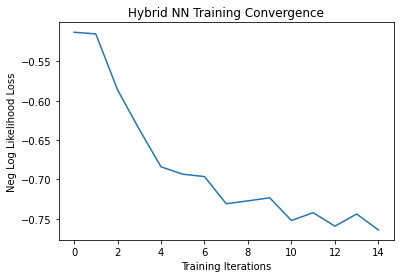

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 15
loss_listE = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listE.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listE[-1]))

#Now plotting the training graph
plt.plot(loss_listE)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7514
	Accuracy: 80.5%


Training [10%]	Loss: -0.4781
Training [20%]	Loss: -0.5393
Training [30%]	Loss: -0.6002
Training [40%]	Loss: -0.6337
Training [50%]	Loss: -0.6676
Training [60%]	Loss: -0.6564
Training [70%]	Loss: -0.7034
Training [80%]	Loss: -0.6097
Training [90%]	Loss: -0.6849
Training [100%]	Loss: -0.7284


Text(0, 0.5, 'Neg Log Likelihood Loss')

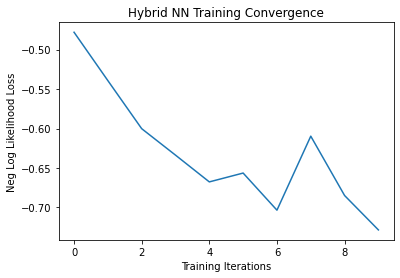

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_list1 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list1.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list1[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list1)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.6887
	Accuracy: 68.5%


Training [7%]	Loss: -0.4813
Training [13%]	Loss: -0.5063
Training [20%]	Loss: -0.5915
Training [27%]	Loss: -0.6660
Training [33%]	Loss: -0.7238
Training [40%]	Loss: -0.7539
Training [47%]	Loss: -0.7539
Training [53%]	Loss: -0.7684
Training [60%]	Loss: -0.7934
Training [67%]	Loss: -0.7796
Training [73%]	Loss: -0.7994
Training [80%]	Loss: -0.7902
Training [87%]	Loss: -0.7914
Training [93%]	Loss: -0.7564
Training [100%]	Loss: -0.8059


Text(0, 0.5, 'Neg Log Likelihood Loss')

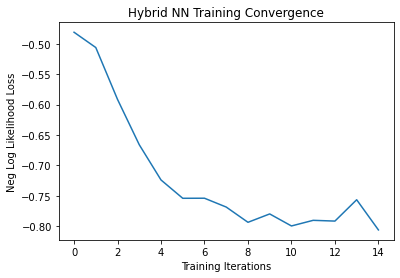

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 15
loss_list2 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list2.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list2[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list2)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7983
	Accuracy: 84.5%


Training [5%]	Loss: -0.4961
Training [10%]	Loss: -0.5808
Training [15%]	Loss: -0.6102
Training [20%]	Loss: -0.6513
Training [25%]	Loss: -0.6665
Training [30%]	Loss: -0.7114
Training [35%]	Loss: -0.6940
Training [40%]	Loss: -0.7227
Training [45%]	Loss: -0.7625
Training [50%]	Loss: -0.7409
Training [55%]	Loss: -0.7521
Training [60%]	Loss: -0.7733
Training [65%]	Loss: -0.7697
Training [70%]	Loss: -0.7871
Training [75%]	Loss: -0.8007
Training [80%]	Loss: -0.8092
Training [85%]	Loss: -0.8251
Training [90%]	Loss: -0.8116
Training [95%]	Loss: -0.8279
Training [100%]	Loss: -0.8335


Text(0, 0.5, 'Neg Log Likelihood Loss')

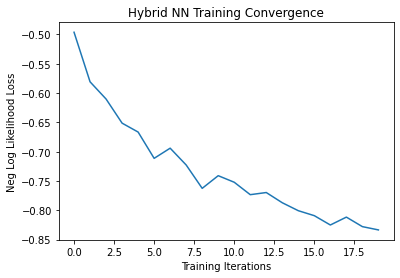

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list3 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list3.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list3[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list3)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.8126
	Accuracy: 85.5%


Training [3%]	Loss: -0.4958
Training [7%]	Loss: -0.4891
Training [10%]	Loss: -0.5213
Training [13%]	Loss: -0.5415
Training [17%]	Loss: -0.5187
Training [20%]	Loss: -0.5270
Training [23%]	Loss: -0.4932
Training [27%]	Loss: -0.5266
Training [30%]	Loss: -0.4594
Training [33%]	Loss: -0.5536
Training [37%]	Loss: -0.4857
Training [40%]	Loss: -0.5060
Training [43%]	Loss: -0.4751
Training [47%]	Loss: -0.5343
Training [50%]	Loss: -0.5546
Training [53%]	Loss: -0.5552
Training [57%]	Loss: -0.5712
Training [60%]	Loss: -0.5173
Training [63%]	Loss: -0.5098
Training [67%]	Loss: -0.5274
Training [70%]	Loss: -0.5229
Training [73%]	Loss: -0.4945
Training [77%]	Loss: -0.5258
Training [80%]	Loss: -0.5115
Training [83%]	Loss: -0.5394
Training [87%]	Loss: -0.5267
Training [90%]	Loss: -0.5083
Training [93%]	Loss: -0.4959
Training [97%]	Loss: -0.5393
Training [100%]	Loss: -0.4987


Text(0, 0.5, 'Neg Log Likelihood Loss')

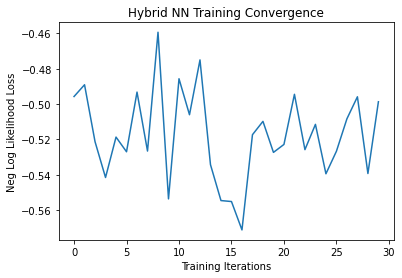

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list4 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list4.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list4[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list4)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.4983
	Accuracy: 48.0%


Training [20%]	Loss: -0.4947
Training [40%]	Loss: -0.5065
Training [60%]	Loss: -0.5075
Training [80%]	Loss: -0.5136
Training [100%]	Loss: -0.5222


Text(0, 0.5, 'Neg Log Likelihood Loss')

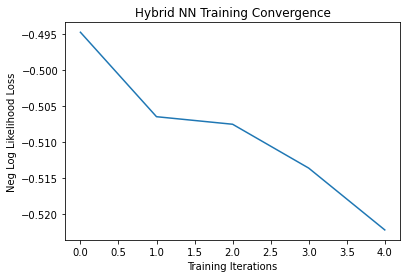

In [ ]:
model = Net()
optimizer = optim.Adamax(model.parameters(), lr=0.0001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list4 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list4.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list4[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list4)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.5256
	Accuracy: 54.5%


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training [20%]	Loss: 0.7149
Training [40%]	Loss: 0.6964
Training [60%]	Loss: 0.6613
Training [80%]	Loss: 0.6053
Training [100%]	Loss: 0.5823


Text(0, 0.5, 'Cross Entropy loss')

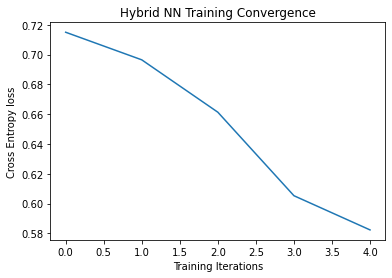

In [16]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 5
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

#Now plotting the training graph
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy loss')

In [17]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: 0.5849
	Accuracy: 76.5%


Training [10%]	Loss: 0.6930
Training [20%]	Loss: 0.6607
Training [30%]	Loss: 0.5770
Training [40%]	Loss: 0.5485
Training [50%]	Loss: 0.5355
Training [60%]	Loss: 0.5304
Training [70%]	Loss: 0.4998
Training [80%]	Loss: 0.4992
Training [90%]	Loss: 0.4784
Training [100%]	Loss: 0.4727


Text(0, 0.5, 'Cross Entropy loss')

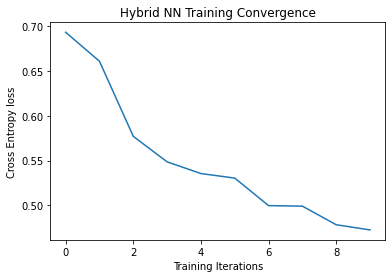

In [18]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
loss_listK = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listK.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listK[-1]))

#Now plotting the training graph
plt.plot(loss_listK)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy loss')

In [19]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: 0.4951
	Accuracy: 80.0%


Training [7%]	Loss: 0.7033
Training [13%]	Loss: 0.6849
Training [20%]	Loss: 0.6151
Training [27%]	Loss: 0.5634
Training [33%]	Loss: 0.6642
Training [40%]	Loss: 0.7150
Training [47%]	Loss: 0.7586
Training [53%]	Loss: 0.6197
Training [60%]	Loss: 0.5635
Training [67%]	Loss: 0.5254
Training [73%]	Loss: 0.5178
Training [80%]	Loss: 0.5134
Training [87%]	Loss: 0.5097
Training [93%]	Loss: 0.4928
Training [100%]	Loss: 0.5091


Text(0, 0.5, 'Cross Entropy loss')

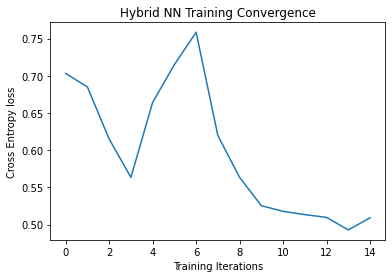

In [26]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 15
loss_listL = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listL.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listL[-1]))

#Now plotting the training graph
plt.plot(loss_listL)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy loss')

In [27]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: 0.5097
	Accuracy: 84.0%


Training [20%]	Loss: 1.4012
Training [40%]	Loss: 1.4011
Training [60%]	Loss: 1.4008
Training [80%]	Loss: 1.4007
Training [100%]	Loss: 1.4007


Text(0, 0.5, 'NLL with Poisson distribution.')

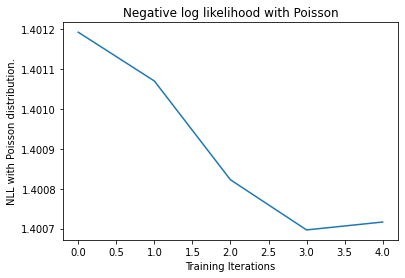

In [35]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.PoissonNLLLoss()

epochs = 5
loss_listK = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listK.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listK[-1]))

#Now plotting the training graph
plt.plot(loss_listK)
plt.title('Negative log likelihood with Poisson')
plt.xlabel('Training Iterations')
plt.ylabel('NLL with Poisson distribution.')

In [36]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: 1.4008
	Accuracy: 52.0%


# TESTING WITH A LEARNING RATE OF 0.0005 

Training [20%]	Loss: -0.4733
Training [40%]	Loss: -0.5273
Training [60%]	Loss: -0.6506
Training [80%]	Loss: -0.6796
Training [100%]	Loss: -0.7229


Text(0, 0.5, 'Negative log Likelihood loss')

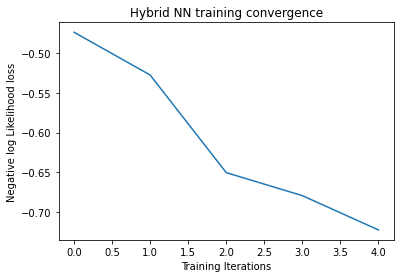

In [40]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 5
loss_listM = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listM.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listM[-1]))

#Now plotting the training graph
plt.plot(loss_listM)
plt.title('Hybrid NN training convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Negative log Likelihood loss')

In [41]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7289
	Accuracy: 82.0%


Changing the number of epochs to 10

Training [10%]	Loss: -0.4944
Training [20%]	Loss: -0.6271
Training [30%]	Loss: -0.6979
Training [40%]	Loss: -0.7217
Training [50%]	Loss: -0.7218
Training [60%]	Loss: -0.7274
Training [70%]	Loss: -0.7677
Training [80%]	Loss: -0.7716
Training [90%]	Loss: -0.7498
Training [100%]	Loss: -0.7872


Text(0, 0.5, 'Negative log Likelihood loss')

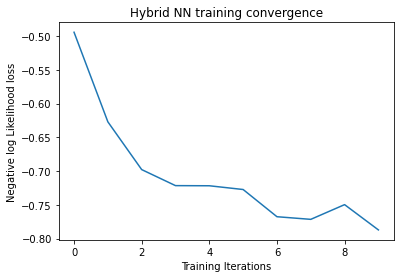

In [45]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 10
loss_listM = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listM.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listM[-1]))

#Now plotting the training graph
plt.plot(loss_listM)
plt.title('Hybrid NN training convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Negative log Likelihood loss')

In [46]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7647
	Accuracy: 80.5%


Epochs raised to 15

Training [7%]	Loss: -0.4962
Training [13%]	Loss: -0.5371
Training [20%]	Loss: -0.5815
Training [27%]	Loss: -0.6426
Training [33%]	Loss: -0.6793
Training [40%]	Loss: -0.7164
Training [47%]	Loss: -0.7258
Training [53%]	Loss: -0.7159
Training [60%]	Loss: -0.7543
Training [67%]	Loss: -0.7614
Training [73%]	Loss: -0.7484
Training [80%]	Loss: -0.7639
Training [87%]	Loss: -0.7611
Training [93%]	Loss: -0.7753
Training [100%]	Loss: -0.8032


Text(0, 0.5, 'Negative log Likelihood loss')

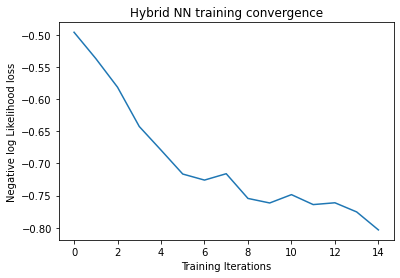

In [47]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 15
loss_listM = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listM.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listM[-1]))

#Now plotting the training graph
plt.plot(loss_listM)
plt.title('Hybrid NN training convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Negative log Likelihood loss')

In [53]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7590
	Accuracy: 82.0%


Training [5%]	Loss: -0.5099
Training [10%]	Loss: -0.5271
Training [15%]	Loss: -0.4963
Training [20%]	Loss: -0.5079
Training [25%]	Loss: -0.5261
Training [30%]	Loss: -0.5108
Training [35%]	Loss: -0.5325
Training [40%]	Loss: -0.5318
Training [45%]	Loss: -0.4902
Training [50%]	Loss: -0.4763
Training [55%]	Loss: -0.4994
Training [60%]	Loss: -0.4786
Training [65%]	Loss: -0.4746
Training [70%]	Loss: -0.4978
Training [75%]	Loss: -0.4821
Training [80%]	Loss: -0.5806
Training [85%]	Loss: -0.6653
Training [90%]	Loss: -0.7098
Training [95%]	Loss: -0.7272
Training [100%]	Loss: -0.7236


Text(0, 0.5, 'Negative log Likelihood loss')

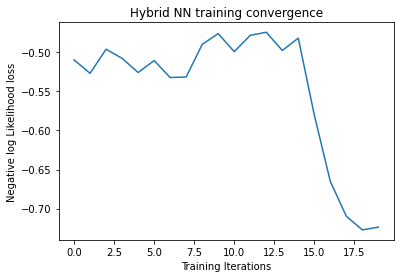

In [62]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.NLLLoss()

epochs = 20
loss_listM = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listM.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listM[-1]))

#Now plotting the training graph
plt.plot(loss_listM)
plt.title('Hybrid NN training convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Negative log Likelihood loss')

In [63]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7237
	Accuracy: 77.5%


# Now we change the loss function to Cross Entropy Loss while using the learning rate of 0.0005 from above.

Training [20%]	Loss: 0.7081
Training [40%]	Loss: 0.6180
Training [60%]	Loss: 0.5978
Training [80%]	Loss: 0.5610
Training [100%]	Loss: 0.5407


Text(0, 0.5, 'Cross Entropy Loss')

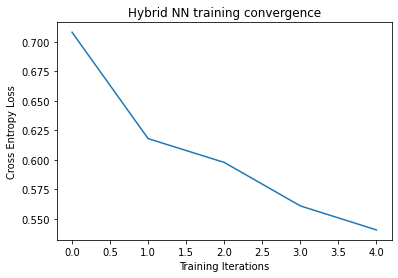

In [55]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.CrossEntropyLoss()

epochs = 5
loss_listN = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listN.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listN[-1]))

#Now plotting the training graph
plt.plot(loss_listN)
plt.title('Hybrid NN training convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')

In [57]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: 0.5401
	Accuracy: 81.0%


Training [10%]	Loss: 0.6808
Training [20%]	Loss: 0.5959
Training [30%]	Loss: 0.5629
Training [40%]	Loss: 0.5632
Training [50%]	Loss: 0.5498
Training [60%]	Loss: 0.5462
Training [70%]	Loss: 0.4943
Training [80%]	Loss: 0.5076
Training [90%]	Loss: 0.4926
Training [100%]	Loss: 0.4696


Text(0, 0.5, 'Cross Entropy Loss')

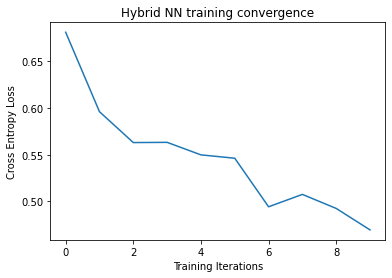

In [58]:
#changing epochs

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.CrossEntropyLoss()

epochs = 10
loss_listN = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listN.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listN[-1]))

#Now plotting the training graph
plt.plot(loss_listN)
plt.title('Hybrid NN training convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')


In [59]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: 0.4891
	Accuracy: 82.0%


Training [7%]	Loss: 0.6955
Training [13%]	Loss: 0.6907
Training [20%]	Loss: 0.6243
Training [27%]	Loss: 0.5649
Training [33%]	Loss: 0.5456
Training [40%]	Loss: 0.5145
Training [47%]	Loss: 0.4917
Training [53%]	Loss: 0.4882
Training [60%]	Loss: 0.5037
Training [67%]	Loss: 0.4849
Training [73%]	Loss: 0.4837
Training [80%]	Loss: 0.4738
Training [87%]	Loss: 0.4743
Training [93%]	Loss: 0.4534
Training [100%]	Loss: 0.4402


Text(0, 0.5, 'Cross Entropy Loss')

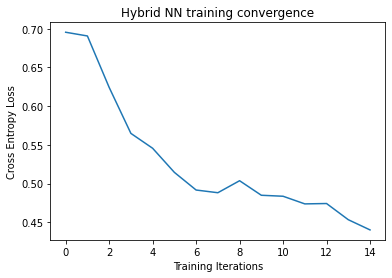

In [60]:
#epochs to 15

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_func = nn.CrossEntropyLoss()

epochs = 15
loss_listN = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_listN.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_listN[-1]))

#Now plotting the training graph
plt.plot(loss_listN)
plt.title('Hybrid NN training convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')


In [61]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: 0.4642
	Accuracy: 83.0%
